$$
\newcommand{\ped}[1]{_{\mathrm{#1}}}
\newcommand{\ap}[1]{^{\mathrm{#1}}}
\newcommand{\nvector}[1]{\mathbf{#1}}
\newcommand{\nmatrix}[1]{\mathit{#1}}
\newcommand{\unitvector}[1]{\hat{\nvector{e}}_{#1}}
\newcommand{\volume}{\mathcal{V}}
\newcommand{\average}[1]{\overline{#1}}
\newcommand{\rate}[1]{\dot{#1}}
\newcommand{\flux}[1]{{#1}''}
\newcommand{\curl}[1]{\nabla\times {#1}}
\newcommand{\curlv}[1]{\curl{\nvector{#1}}}
\newcommand{\divergent}[1]{\nabla \cdot #1}
\newcommand{\divergentv}[1]{\divergent{\nvector{#1}}}
\newcommand{\divergentpar}[1]{\divergent{\left( #1 \right)}}
\newcommand{\gradient}[1]{\nabla {#1}}
\newcommand{\gradientpar}[1]{\gradient{\left( {#1} \right)}}
\newcommand{\laplacian}[1]{\nabla^2 #1}
\newcommand{\laplacianpar}[1]{\laplacian{\left( #1 \right)}}
\newcommand{\vectornorm}[1]{\left\lVert #1 \right\rVert}
\newcommand{\diffp}[2]{\frac{\partial {#1}}{\partial {#2}}}
\newcommand{\diffps}[2]{\frac{\partial^2 {#1}}{\partial {#2}^2}}
\newcommand{\rvec}{\nvector{r}}
\newcommand{\nvh}{\nvector{H}}
\newcommand{\nvb}{\nvector{B}}
\newcommand{\nvrem}{\nvector{B}\ped{rem}}
\newcommand{\nvbrem}{\nvrem}
\newcommand{\nvm}{\nvector{M}}
\newcommand{\mur}{\mu\ped{r}}
\newcommand{\nvbremhat}{\hat{\nvector{B}}\ped{rem}}
\newcommand{\acoef}[2]{a_{{#1},\mathrm{#2}}}
\newcommand{\bcoef}[2]{b_{{#1},\mathrm{#2}}}
\newcommand{\Azexpr}[1]{A_{\mathrm{#1}\, z}}
\newcommand{\bremii}{B_{\mathrm{rem,II}}}
\newcommand{\bremiv}{B_{\mathrm{rem,IV}}}
\newcommand{\aIII}{\acoef{1}{III}}
\newcommand{\bIII}{\bcoef{1}{III}}
\newcommand{\nvbIII}{\nvector{B}\ped{III}}
\newcommand{\BIII}{B\ped{III}}
\newcommand{\diffd}[1]{\mathrm{d}\,{#1}}
$$

# Application of the virtual magnet method to the teslamax system

Tell the location of the TeslaMax Java class file:

In [1]:
from pathlib import Path
import os
import subprocess
import math
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib
matplotlib.use('nbagg')
from matplotlib.patches import Wedge
import matplotlib.pyplot as plt
from scipy.interpolate import  NearestNDInterpolator, LinearNDInterpolator, CloughTocher2DInterpolator,griddata



mpl_params = {'text.usetex': True,
              'font.family': 'serif',
              'font.serif': 'Computer Modern',
              'text.latex.preamble': [r'\usepackage{engsymbols}',
                                      r'\usepackage{magref}',
                                      r'\usepackage{siunitx}']}
matplotlib.rcParams.update(mpl_params)


In [2]:
SAVE_FIG_Q = True
FIGURES_DIR_NAME = "figures"
FIG_FILE_PATH = Path('.')

FIGSIZE_CM = 20
FIGSIZE_INCHES = FIGSIZE_CM/2.54

FONTSIZE = 18


FIGSIZE_CM_SMALL = 8
FIGSIZE_INCHES_SMALL = FIGSIZE_CM_SMALL/2.54
FONTSIZE_SMALL = 12

MARKERSIZE = 8.0

PLOT_EXTENSION = '.png'

DPI = 650

In [3]:
comsol_virtual_magnet_dir = Path.home() / 'Google Drive' / 'PoloMag' / 'AMR and Magnet Design' / 'COMSOL' / 'virtual-magnet'

In [4]:
comsol_virtual_magnet_dir.exists()

True

In [5]:
PARAM_FILE = "virtual_parameters.txt"

VIRTUAL_WHOLE_GEOMETRY_FILENAME = "Virtual_Magnet_Data_Full.txt"
VIRTUAL_DESIGN_REGION_FILENAME = "Virtual_Magnet_Data_Design_Region.txt"

VIRTUAL_IRON_WHOLE_GEOMETRY_FILENAME = "Virtual_Magnet_Iron_Data_Full.txt"
VIRTUAL_IRON_DESIGN_REGION_FILENAME = "Virtual_Magnet_Iron_Data_Design_Region.txt"


Other constants:

In [6]:
N_PROFILE_POINTS = 100

N_POINTS_PER_AXIS = 400

N_POINTS_REMANENCE_R= 1

N_POINTS_REMANENCE_PHI = 5

Some auxiliary functions to process the results:

In [49]:
def normalize_vector(v):
    """
    Return the normalized (dimensionless) form of vector (or list of vectors) v"""
    
    # v could be a single vector or a list of vectors, so we handle different cases
    if v.ndim == 1:
        return v/np.linalg.norm(v)
    else:
        v_norm = np.linalg.norm(v,axis=1)
        v_norm_inv = np.reciprocal(v_norm).reshape(len(v),1)
        return np.multiply(v,v_norm_inv)

In [7]:
def get_comsol_parameters_series():
    """Parse the COMSOL parameters file in the current directory and
    return a pandas Series from it.
    
    """
    param_comsol_file = Path('.') / COMSOL_PARAMETER_FILENAME

    param_comsol_series = pd.read_table(str(param_comsol_file),
                                        squeeze=True,
                                        sep=" ",
                                        index_col=0,
                                        header=None)

    param_comsol_series.name = "COMSOL Parameters"
    param_comsol_series.index.name = None
    
    # append the units to the parameters names
    names_with_units = {}
    for name in param_comsol_series.keys():
        if name.startswith("h_") or name.startswith("R_"):
            names_with_units[name] = name+"[m]"
        if name.startswith("alpha") or name.startswith("phi") or name.startswith("delta_phi"):
            names_with_units[name] = name + "[deg]"
        if name.startswith("B_"):
            names_with_units[name] = name + "[T]"
        if name.startswith("H_c"):
            names_with_units[name] = name + "[A/m]"

    param_comsol_series = param_comsol_series.rename(names_with_units)
    return param_comsol_series

In [8]:
def read_comsol_data_file(filename):
    """Read and parse 'filename' as exported by COMSOL.
    Export the numerical data as a numpy array containing only the numerical
    data; the first two columns are x and y values. All values are in SI.
    
    Keyword Arguments:
    filename -- str
    """

    return np.loadtxt(filename,skiprows=9)

In [9]:
def process_main_results_file():
    """Take the file "COMSOL Main Results.txt" as exported by COMSOL and
    clean the header data.
    
    """
    
    p = Path('.') / MAIN_RESULTS_FILENAME

    param_comsol_series = get_comsol_parameters_series()

    results = pd.read_table(MAIN_RESULTS_FILENAME,
                            sep="\s+",
                            skiprows=5,
                            index_col=None,
                            header=None,
                            names=["B_high[T]",
                                   "B_low[T]",
                                   "A_gap[m2]",
                                   "A_magnet[m2]",
                                   "-H_Brem_II_max[A/m]",
                                   "-H_Brem_IV_max[A/m]"])
    
    results_series = results.ix[0]
       
    results_series.to_csv(str(p),
                       float_format="%.6f",
                       sep=" ",
                       index=True)

In [10]:
def read_main_results_file():
    """Return a Series where each row is one of the COMSOL Main results"""
    
    results_filepath = Path(MAIN_RESULTS_FILENAME)

    results_series = pd.read_table(results_filepath,
                              sep=" ",
                              squeeze=True,
                              index_col=0,
                              header=None)
    results_series.index.name=None
    results_series.name = "COMSOL Main Results"
    return results_series

In [11]:
def write_magnetic_profile_file():
    """Create a file "COMSOL Magnetic Profile.txt" in the current directory,
    assuming the teslamax command was already ran, and write the magnetic
    profile data (average magnetic induction over radial chords).
    
    """
    
    p = Path('.') / MAGNETIC_PROFILE_FILENAME
    column_names = ["phi[deg]","B[T]"]
    column_header = " ".join(column_names)
    
    # load data from the high and low field regions
    B_h = read_comsol_data_file(B_HIGH_FILENAME)
    B_l = read_comsol_data_file(B_LOW_FILENAME)
    
    B_1q = np.concatenate((B_h,B_l),axis=0)
    
    # calcualte vector of angles for the first quadrant
    case_series = get_comsol_parameters_series()
    
    n_phi_points = 200
    
    R_g = case_series['R_g[m]']
    R_o = case_series['R_o[m]']
    
    
    # create ranges for phi and r
    phi_min = 0.0
    phi_max = np.pi/2
    
    phi_vector_1q = np.linspace(phi_min,phi_max,N_PROFILE_POINTS)
    
    # slightly offset the boundaries to avoid numerical problems at the interfaces
    r_min = 1.001*R_o 
    r_max = 0.999*R_g
    n_r_points = 5
    
    r_vector = np.linspace(r_min,r_max,n_r_points)
    
    r_grid, phi_grid = np.meshgrid(r_vector,phi_vector_1q)
    
    # calcualte the points (x,y) distributed along
    # radial lines
    x_grid = r_grid * np.cos(phi_grid)
    y_grid = r_grid * np.sin(phi_grid)
    
    # create a interpolation function over the 1st quadrant grid
    # we use the nearest interpolation to avoid negative values
    # when fitting a spline near points where B = 0
    
    #fB = NearestNDInterpolator(x=B_1q[:,0:2],y=B_1q[:,2])
    fB = CloughTocher2DInterpolator(B_1q[:,0:2],B_1q[:,2])

    # because both x_grid and y_grid have shape (n_r_points, N_PROFILE_POINTS),
    # when we apply the above created function we will get an array with the
    # same shape. We then take the average value along each row,
    # resuting in an array (N_PROFILE_POINTS)
    B_profile_1q = np.mean(fB(x_grid,y_grid),axis=1)

    # extrapolate data to the full circle
    phi_vector = np.concatenate((phi_vector_1q,
                                 phi_vector_1q+np.pi/2,
                                 phi_vector_1q+np.pi,
                                 phi_vector_1q+(3/2)*np.pi))

    B_profile = np.concatenate((B_profile_1q,
                                B_profile_1q[::-1],
                                B_profile_1q,
                                B_profile_1q[::-1]))

    profile_data = np.array((np.rad2deg(phi_vector),B_profile)).T
    
    np.savetxt(str(p),
               profile_data,
               fmt=("%.2f","%.5f"),
               delimiter=" ",
               header=column_header,
               comments='')
    

In [12]:
def write_magnetic_profile_central_file():
    """Create a file "COMSOL Magnetic Profile.txt" in the current directory,
    assuming the teslamax command was already ran, and write the magnetic
    profile data (magnetic induction at central radial position).
    
    """
    
    p = Path('.') / MAGNETIC_PROFILE_FILENAME
    column_names = ["phi[deg]","B[T]"]
    column_header = " ".join(column_names)
    
    # load data from the high and low field regions
    B_h = read_comsol_data_file(B_HIGH_FILENAME)
    B_l = read_comsol_data_file(B_LOW_FILENAME)
    
    B_1q = np.concatenate((B_h,B_l),axis=0)
    
    # calcualte vector of angles for the first quadrant
    case_series = get_comsol_parameters_series()
    
    n_phi_points = 100
    
    R_g = case_series['R_g[m]']
    R_o = case_series['R_o[m]']
    
    
    # create ranges for phi and r
    phi_min = 0.0
    phi_max = np.pi/2
    
    phi_vector_1q = np.linspace(phi_min,phi_max,N_PROFILE_POINTS)
    
    r_min = R_o 
    r_max = R_g
    
    r_central = .5*(R_o + R_g)

    
    # calcualte the points (x,y) distributed along
    # radial lines
    x_grid = r_central * np.cos(phi_vector_1q)
    y_grid = r_central * np.sin(phi_vector_1q)

    B_profile_1q = griddata(B_1q[:,0:2],B_1q[:,2],np.array([x_grid,y_grid]).T)

    # extrapolate data to the full circle
    phi_vector = np.concatenate((phi_vector_1q,
                                 phi_vector_1q+np.pi/2,
                                 phi_vector_1q+np.pi,
                                 phi_vector_1q+(3/2)*np.pi))

    B_profile = np.concatenate((B_profile_1q,
                                B_profile_1q[::-1],
                                B_profile_1q,
                                B_profile_1q[::-1]))

    profile_data = np.array((np.rad2deg(phi_vector),B_profile)).T
    
    np.savetxt(str(p),
               profile_data,
               fmt=("%.2f","%.5f"),
               delimiter=" ",
               header=column_header,
               comments='')
    

In [13]:
def run_teslamax(verbose=False):
    """Run the teslamax process in the current directory, clean the results file 
    and create a magnetic profile file.
    
    Assumes the parameters file is present in the current directory."""
    comsol_process = subprocess.run(comsol_cmd,shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT,universal_newlines=True)
    if verbose: print(comsol_process.stdout)
    process_main_results_file()
    write_magnetic_profile_file()
    #write_magnetic_profile_central_file()

In [14]:
def remove_units_from_dict_keys(dictionary):
    """Remove a string '[<anything>]' from every key of 'dictionary'"""
    
    new_dictionary = {}
    
    for key in dictionary.keys():
        new_key = key.split('[')[0]
        new_dictionary[new_key] = dictionary[key]
        
    return new_dictionary

In [15]:
def write_parameter_file_from_dict(param_dict):
    """From a basic 'param_dict', calculate the necessary other parameters 
    (e.g. magnet segment size from total size and number of segments) and write 
    the correct parameters file.
    
    If 'param_dict' contains units in the names, they are removed.
    """
    
    param_dict = remove_units_from_dict_keys(param_dict)
    
    # cast the number of segments to int, if necessary
    param_dict["n_IV"] = int(param_dict["n_IV"])
    
    # remove some keys that are not necessary (and which may cause errors)
    try:
        del param_dict["-H_Brem_IV_max"]
    except:
        pass
    
    param_dict["R_g"] = param_dict["R_o"] + param_dict["h_gap"]
    param_dict["R_c"] = param_dict["R_s"] + param_dict["h_fc"]
    if param_dict["n_II"] > 0:
        param_dict["delta_phi_S_II"] = (param_dict["phi_S_II"] - param_dict["phi_C_II"]) / param_dict["n_II"]
    if param_dict["n_IV"] > 0:
        param_dict["delta_phi_S_IV"] = param_dict["phi_S_IV"] / param_dict["n_IV"]
    
    parameters_file_path = Path(".") / COMSOL_PARAMETER_FILENAME
    
    param_text = ""
    
    for (key, value) in param_dict.items():
        param_text = param_text + "%s %s\n" %(key,value)
    
    parameters_file_path.write_text(param_text)

In [16]:
def run_teslamax_from_params(params,verbose=False):
    """Write the 'params' dictionary in the apropriate format to the current directory
    (removing units if necessary) and run the teslamax process"""
    write_parameter_file_from_dict(params)
    run_teslamax(verbose)

In [17]:
def generate_full_circle_mesh_points(R1,R2):
    """
    Return a list of points [X,Y] uniformily distributed in a circle between radii R1 and R2.
    
    The number of points is controlled by N_POINTS_PER_AXIS.
    """
    
    phi_min = 0.0
    phi_max = 2*np.pi
    
    phi_vector = np.linspace(phi_min,phi_max,N_POINTS_PER_AXIS)
    
    r_vector = np.linspace(R1,R2,N_POINTS_PER_AXIS)
    
    phi_grid, r_grid = np.meshgrid(phi_vector,r_vector)
    
    X_vector = (r_grid*np.cos(phi_grid)).flatten()
    Y_vector = (r_grid*np.sin(phi_grid)).flatten()
    
    return np.array([X_vector,Y_vector]).T

In [18]:
def generate_quarter_circle_quiver_points(R1,R2,phi1,phi2):
    """
    Return a list of discrete points [X,Y] where a vector field (quiver) is supposed to be plotted, for 
    a quarter circle between radii R1 and R2 and angular positions phi1 and phi2
    
    The number of points generated is controlled by N_POINTS_REMANENCE_PHI and N_POINTS_REMANENCE_R. 
    """
    
    phi_min = phi1
    phi_max = phi2
    
    # The 0.9 factor results in better plotting
    phi_vector = np.linspace(phi_min,0.9*phi_max,N_POINTS_REMANENCE_PHI)
    
    r_II_min = R1 + 1.0/3*(R2-R1)
    r_II_max = R1 + 2.0/3*(R2-R1)
    r_vector = np.linspace(r_II_min,r_II_max,N_POINTS_REMANENCE_R)
    
    phi_grid, r_grid = np.meshgrid(phi_vector,r_vector)
    
    X_vector = (r_grid*np.cos(phi_grid)).flatten()
    Y_vector = (r_grid*np.sin(phi_grid)).flatten()
    
    return np.array([X_vector,Y_vector]).T
    

In [19]:
def create_full_circle_figure_template(params):
    """
    Return (fig,axes) correspondent to a figure of the full design region
    
    
    The size of the figure is controlled by FIGSIZE_INCHES"""
    
    fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
    axes = fig.add_subplot(111,aspect='equal')
    
    r_lim = 1.1*params['R_e']
    
    axes.set_ylim(-1e3*r_lim,1e3*r_lim)
    axes.set_xlim(-1e3*r_lim,1e3*r_lim)

    axes.set_ylabel(r'$y\ [\si{\mm}$]')
    axes.set_xlabel(r'$x\ [\si{\mm}$]')
    
    R_o = params['R_o']
    R_g = params['R_g']
    R_e = params['R_e']
    
    inner_circle=plt.Circle((0,0),1e3*R_o,color='k',fill=False)
    axes.add_artist(inner_circle)
    
    virtual_xpos = Wedge((0,0),1e3*R_g,-45,45,1e3*(R_g-R_o),color='k',fill=False)
    virtual_xneg = Wedge((0,0),1e3*R_g,135,225,1e3*(R_g-R_o),color='k',fill=False)
    virtual_ypos = Wedge((0,0),1e3*R_g,45,135,1e3*(R_g-R_o),color='k',fill=False)
    virtual_yneg = Wedge((0,0),1e3*R_g,225,-45,1e3*(R_g-R_o),color='k',fill=False)
    axes.add_artist(virtual_xpos)
    axes.add_artist(virtual_xneg)
    axes.add_artist(virtual_ypos)
    axes.add_artist(virtual_yneg)
    
    environment_outer=plt.Circle((0,0),1e3*R_e,color='k',fill=False)
    environment_inner=plt.Circle((0,0),1e3*R_g,color='k',fill=False)
    axes.add_artist(environment_outer)
    axes.add_artist(environment_inner)
    
    return fig, axes

In [92]:
def create_full_circle_iron_figure_template(params):
    """
    Return (fig,axes) correspondent to a figure of the full design region, with iron wedges
    
    
    The size of the figure is controlled by FIGSIZE_INCHES"""
    
    fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
    axes = fig.add_subplot(111,aspect='equal')
    
    r_lim = 1.1*params['R_e']
    
    axes.set_ylim(-1e3*r_lim,1e3*r_lim)
    axes.set_xlim(-1e3*r_lim,1e3*r_lim)

    axes.set_ylabel(r'$y\ [\si{\mm}$]')
    axes.set_xlabel(r'$x\ [\si{\mm}$]')
    
    R_o = params['R_o']
    R_g = params['R_g']
    R_e = params['R_e']
    
    inner_xpos = Wedge((0,0),1e3*R_o,-45,45,color='k',fill=False)
    inner_xneg = Wedge((0,0),1e3*R_o,135,225,color='k',fill=False)
    inner_ypos = Wedge((0,0),1e3*R_o,45,135,edgecolor='k',facecolor='0.75',fill=True)
    inner_yneg = Wedge((0,0),1e3*R_o,225,-45,edgecolor='k',facecolor='0.75',fill=True)
    axes.add_artist(inner_xpos)
    axes.add_artist(inner_xneg)
    axes.add_artist(inner_ypos)
    axes.add_artist(inner_yneg)
    
    virtual_xpos = Wedge((0,0),1e3*R_g,-45,45,1e3*(R_g-R_o),color='k',fill=False)
    virtual_xneg = Wedge((0,0),1e3*R_g,135,225,1e3*(R_g-R_o),color='k',fill=False)
    virtual_ypos = Wedge((0,0),1e3*R_g,45,135,1e3*(R_g-R_o),color='k',fill=False)
    virtual_yneg = Wedge((0,0),1e3*R_g,225,-45,1e3*(R_g-R_o),color='k',fill=False)
    axes.add_artist(virtual_xpos)
    axes.add_artist(virtual_xneg)
    axes.add_artist(virtual_ypos)
    axes.add_artist(virtual_yneg)
    
    outer_xpos = Wedge((0,0),1e3*R_e,-45,45,1e3*(R_e-R_g),color='k',fill=False)
    outer_xneg = Wedge((0,0),1e3*R_e,135,225,1e3*(R_e-R_g),color='k',fill=False)
    outer_ypos = Wedge((0,0),1e3*R_e,45,135,1e3*(R_e-R_g),edgecolor='k',facecolor='0.75',fill=True)
    outer_yneg = Wedge((0,0),1e3*R_e,225,-45,1e3*(R_e-R_g),edgecolor='k',facecolor='0.75',fill=True)
    axes.add_artist(outer_xpos)
    axes.add_artist(outer_xneg)
    axes.add_artist(outer_ypos)
    axes.add_artist(outer_yneg)
    
    return fig, axes

In [20]:
def save_and_close_figure(fig,name):
    """
    Save the 'fig' Figure object as 'name' (with extension PLOT_EXTENSION), inside FIG_FILE_PATH,
    and close the figure"""
    
    
    file_path = str(FIG_FILE_PATH / (name + PLOT_EXTENSION))
    fig.savefig(file_path,dpi=DPI,bbox_inches='tight')
    plt.close(fig)

## Playground

In [21]:
teslamax_playground = Path("teslamax-play")
teslamax_playground.mkdir(exist_ok=True)
os.chdir(str(teslamax_playground))

In [22]:
# for now we have to enter the parameters by hand
params = {'R_o': 80e-3,
         'R_g': 0.1,
         'R_e': 0.3}

### First analysis - Whole system composed of air

Load the solution data from COMSOL:

In [21]:
virtual_magnet_whole_geometry_file = comsol_virtual_magnet_dir / VIRTUAL_WHOLE_GEOMETRY_FILENAME

In [22]:
virtual_magnet_whole_geometry_file.exists()

True

In [25]:
virtual_magnet_whole_geometry_data = read_comsol_data_file(str(virtual_magnet_whole_geometry_file))

In [28]:
x_vector, y_vector, H_x_vector, H_y_vector, H_vector, Vm_vector = virtual_magnet_whole_geometry_data.T

We create a more structure grid over the domain to create better plots, and interpolate from the COMSOL data:

In [100]:
x_virtual, y_virtual = generate_full_circle_mesh_points(15e-3,params['R_e']).T
x_virtual_2D = x_virtual.reshape((N_POINTS_PER_AXIS,N_POINTS_PER_AXIS))
y_virtual_2D = y_virtual.reshape((N_POINTS_PER_AXIS,N_POINTS_PER_AXIS))
H_virtual_2D = griddata((x_vector,y_vector),H_vector,(x_virtual,y_virtual)).reshape(x_virtual_2D.shape)
Vm_virtual_2D = griddata((x_vector,y_vector),Vm_vector,(x_virtual,y_virtual)).reshape(x_virtual_2D.shape)

Create data for the remanence:

In [191]:
# slightly offest the boundaries to get better plotting:
x_rem_1q_vector, y_rem_1q_vector = generate_quarter_circle_quiver_points(params["R_o"]+2e-3,
                                                                         params["R_g"],
                                                                         np.deg2rad(-40),
                                                                         np.deg2rad(40)).T

x_rem_2q_vector, y_rem_2q_vector = generate_quarter_circle_quiver_points(params["R_o"]+2e-3,
                                                                         params["R_g"]+2e-3,
                                                                         np.deg2rad(140),
                                                                         np.deg2rad(235)).T

We assume that the remanence vectors are oriented radially:

In [192]:
phi_rem_1q_vector = np.arctan2(y_rem_1q_vector,x_rem_1q_vector)

B_rem_x_1q_vector = np.cos(phi_rem_1q_vector)
B_rem_y_1q_vector = np.sin(phi_rem_1q_vector)

In [193]:
phi_rem_2q_vector = np.arctan2(y_rem_2q_vector,x_rem_2q_vector)

B_rem_x_2q_vector = -np.cos(phi_rem_2q_vector)
B_rem_y_2q_vector = -np.sin(phi_rem_2q_vector)

<a list of 20 text.Text objects>

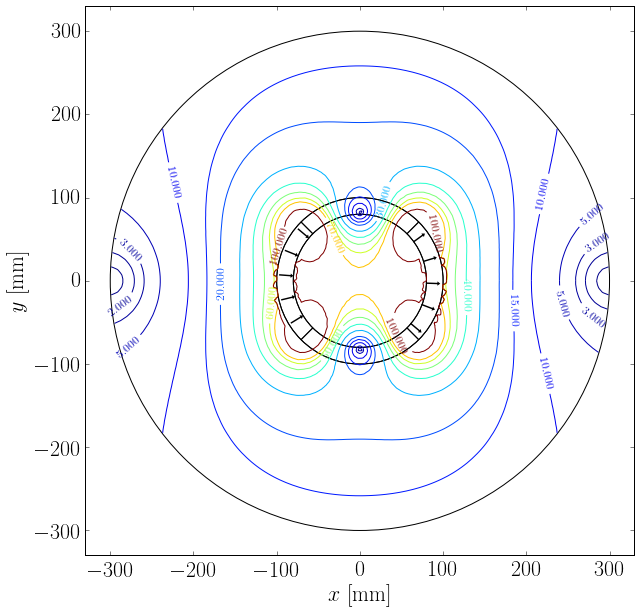

In [204]:
%matplotlib inline

plt.rc('font',size=FONTSIZE)
# -----
# FIGURE - H contours

H_contour_fig, H_contour_axes = create_full_circle_figure_template(params)
H_levels =  [0,1,2,3,5,10,15,20,30,40,50,60,70,100]


H_contours = H_contour_axes.contour(1e3*x_virtual_2D,
                                    1e3*y_virtual_2D,
                                    1e-3*H_virtual_2D,
                                   H_levels)

arrow_scale = 5.0
arrow_width = 0.02
head_axis_length = 2.0
head_length = 2

B_rem_1q_vector_field = H_contour_axes.quiver(1e3*x_rem_1q_vector,
                                              1e3*y_rem_1q_vector,
                                              B_rem_x_1q_vector,
                                              B_rem_y_1q_vector,
                                              units='inches',
                                              pivot='mid',
                                              headlength=head_length,
                                              headaxislength=head_axis_length,
                                              scale_units='inches',
                                              scale=arrow_scale,
                                              width=arrow_width)

B_rem_2q_vector_field = H_contour_axes.quiver(1e3*x_rem_2q_vector,
                                              1e3*y_rem_2q_vector,
                                              B_rem_x_2q_vector,
                                              B_rem_y_2q_vector,
                                              units='inches',
                                              pivot='mid',
                                              headlength=head_length,
                                              headaxislength=head_axis_length,
                                              scale_units='inches',
                                              scale=arrow_scale,
                                              width=arrow_width)

H_contour_axes.clabel(H_contours,fontsize=FONTSIZE_SMALL)

In [233]:
%matplotlib inline

plt.rc('font',size=FONTSIZE)
# -----
# FIGURE - H contours (selected)

H_selected_contour_fig, H_selected_contour_axes = create_full_circle_figure_template(params)
H_levels =  [15,20,70]


H_selected_contours = H_selected_contour_axes.contour(1e3*x_virtual_2D,
                                                      1e3*y_virtual_2D,
                                                      1e-3*H_virtual_2D,
                                                      H_levels,
                                                      colors='k')

arrow_scale = 5.0
arrow_width = 0.02
head_axis_length = 2.0
head_length = 2

B_rem_1q_vector_field = H_selected_contour_axes.quiver(1e3*x_rem_1q_vector,
                                              1e3*y_rem_1q_vector,
                                              B_rem_x_1q_vector,
                                              B_rem_y_1q_vector,
                                              units='inches',
                                              pivot='mid',
                                              headlength=head_length,
                                              headaxislength=head_axis_length,
                                              scale_units='inches',
                                              scale=arrow_scale,
                                              width=arrow_width)

B_rem_2q_vector_field = H_selected_contour_axes.quiver(1e3*x_rem_2q_vector,
                                              1e3*y_rem_2q_vector,
                                              B_rem_x_2q_vector,
                                              B_rem_y_2q_vector,
                                              units='inches',
                                              pivot='mid',
                                              headlength=head_length,
                                              headaxislength=head_axis_length,
                                              scale_units='inches',
                                              scale=arrow_scale,
                                              width=arrow_width)

if SAVE_FIG_Q: save_and_close_figure(H_selected_contour_fig,"H-virtual")

<a list of 19 text.Text objects>

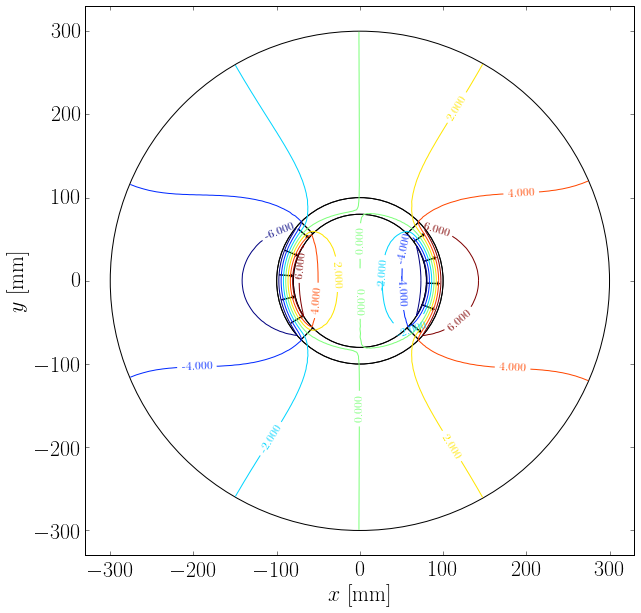

In [224]:
%matplotlib inline

plt.rc('font',size=FONTSIZE)
# -----
# FIGURE - Vm contours

Vm_contour_fig, Vm_contour_axes = create_full_circle_figure_template(params)

Vm_contours = Vm_contour_axes.contour(1e3*x_virtual_2D,
                                      1e3*y_virtual_2D,
                                      1e-3*Vm_virtual_2D,
                                      10)

B_rem_1q_vector_field = Vm_contour_axes.quiver(1e3*x_rem_1q_vector,
                                              1e3*y_rem_1q_vector,
                                              B_rem_x_1q_vector,
                                              B_rem_y_1q_vector,
                                              units='inches',
                                              pivot='mid',
                                              headlength=head_length,
                                              headaxislength=head_axis_length,
                                              scale_units='inches',
                                              scale=arrow_scale,
                                              width=arrow_width)

B_rem_2q_vector_field = Vm_contour_axes.quiver(1e3*x_rem_2q_vector,
                                              1e3*y_rem_2q_vector,
                                              B_rem_x_2q_vector,
                                              B_rem_y_2q_vector,
                                              units='inches',
                                              pivot='mid',
                                              headlength=head_length,
                                              headaxislength=head_axis_length,
                                              scale_units='inches',
                                              scale=arrow_scale,
                                              width=arrow_width)

Vm_contour_axes.clabel(Vm_contours,fontsize=FONTSIZE_SMALL)


In [234]:
%matplotlib inline

plt.rc('font',size=FONTSIZE)
# -----
# FIGURE - Vm contours

Vm_selected_contour_fig, Vm_selected_contour_axes = create_full_circle_figure_template(params)
Vm_levels = [-5,-1,1,5]

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
Vm_selected_contours = Vm_selected_contour_axes.contour(1e3*x_virtual_2D,
                                                        1e3*y_virtual_2D,
                                                        1e-3*Vm_virtual_2D,
                                                        Vm_levels,
                                                        colors='k')

B_rem_1q_vector_field = Vm_selected_contour_axes.quiver(1e3*x_rem_1q_vector,
                                              1e3*y_rem_1q_vector,
                                              B_rem_x_1q_vector,
                                              B_rem_y_1q_vector,
                                              units='inches',
                                              pivot='mid',
                                              headlength=head_length,
                                              headaxislength=head_axis_length,
                                              scale_units='inches',
                                              scale=arrow_scale,
                                              width=arrow_width)

B_rem_2q_vector_field = Vm_selected_contour_axes.quiver(1e3*x_rem_2q_vector,
                                              1e3*y_rem_2q_vector,
                                              B_rem_x_2q_vector,
                                              B_rem_y_2q_vector,
                                              units='inches',
                                              pivot='mid',
                                              headlength=head_length,
                                              headaxislength=head_axis_length,
                                              scale_units='inches',
                                              scale=arrow_scale,
                                              width=arrow_width)

Vm_contour_axes.clabel(Vm_contours,fontsize=FONTSIZE_SMALL)
if SAVE_FIG_Q: save_and_close_figure(Vm_selected_contour_fig,"Vm-virtual")

### Model with iron

In [23]:
virtual_magnet_iron_design_geometry_file = comsol_virtual_magnet_dir / VIRTUAL_IRON_DESIGN_REGION_FILENAME

In [24]:
virtual_magnet_iron_design_geometry_file.exists()

True

In [27]:
virtual_magnet_iron_design_data = read_comsol_data_file(str(virtual_magnet_iron_design_geometry_file))

In [28]:
x_iron_vector, y_iron_vector, H_x_iron_vector, H_y_iron_vector, H_iron_vector, Vm_iron_vector = virtual_magnet_iron_design_data.T

We create a more structure grid over the domain to create better plots, and interpolate from the COMSOL data:

In [79]:
N_POINTS_REMANENCE_R= 3

N_POINTS_REMANENCE_PHI = 4


# inner 1Q
x_iron_inner_1q_virtual, y_iron_inner_1q_virtual = generate_quarter_circle_quiver_points(15e-3,
                                                                                         params["R_o"],
                                                                                         np.deg2rad(-40),
                                                                                         np.deg2rad(40)).T
H_x_iron_inner_1q_virtual = griddata((x_iron_vector,y_iron_vector),
                            H_x_iron_vector,
                            (x_iron_inner_1q_virtual,y_iron_inner_1q_virtual))
H_y_iron_inner_1q_virtual = griddata((x_iron_vector,y_iron_vector),
                            H_y_iron_vector,
                            (x_iron_inner_1q_virtual,y_iron_inner_1q_virtual))

H_x_iron_inner_1q_normalized, H_y_iron_inner_1q_normalized = normalize_vector(np.array([H_x_iron_inner_1q_virtual, 
                                                                                        H_y_iron_inner_1q_virtual]).T).T

# inner 2Q
x_iron_inner_2q_virtual, y_iron_inner_2q_virtual = generate_quarter_circle_quiver_points(15e-3,
                                                                         params["R_o"],
                                                                         np.deg2rad(140),
                                                                         np.deg2rad(235)).T


H_x_iron_inner_2q_virtual = griddata((x_iron_vector,y_iron_vector),
                            H_x_iron_vector,
                            (x_iron_inner_2q_virtual,y_iron_inner_2q_virtual))
H_y_iron_inner_2q_virtual = griddata((x_iron_vector,y_iron_vector),
                            H_y_iron_vector,
                            (x_iron_inner_2q_virtual,y_iron_inner_2q_virtual))

H_x_iron_inner_2q_normalized, H_y_iron_inner_2q_normalized = normalize_vector(np.array([H_x_iron_inner_2q_virtual, 
                                                                                        H_y_iron_inner_2q_virtual]).T).T

# outer 1Q

N_POINTS_REMANENCE_R= 5

N_POINTS_REMANENCE_PHI = 6

x_iron_outer_1q_virtual, y_iron_outer_1q_virtual = generate_quarter_circle_quiver_points(params["R_g"]+2e-3,
                                                                                        params["R_e"],
                                                                                        np.deg2rad(-40),
                                                                                        np.deg2rad(40)).T

H_x_iron_outer_1q_virtual = griddata((x_iron_vector,y_iron_vector),
                            H_x_iron_vector,
                            (x_iron_outer_1q_virtual,y_iron_outer_1q_virtual))
H_y_iron_outer_1q_virtual = griddata((x_iron_vector,y_iron_vector),
                            H_y_iron_vector,
                            (x_iron_outer_1q_virtual,y_iron_outer_1q_virtual))

H_x_iron_outer_1q_normalized, H_y_iron_outer_1q_normalized = normalize_vector(np.array([H_x_iron_outer_1q_virtual, 
                                                                                        H_y_iron_outer_1q_virtual]).T).T



# outer 2Q
x_iron_outer_2q_virtual, y_iron_outer_2q_virtual = generate_quarter_circle_quiver_points(params['R_g']+2e-3,
                                                                                        params["R_e"],
                                                                                        np.deg2rad(140),
                                                                                        np.deg2rad(235)).T

H_x_iron_outer_2q_virtual = griddata((x_iron_vector,y_iron_vector),
                            H_x_iron_vector,
                            (x_iron_outer_2q_virtual,y_iron_outer_2q_virtual))
H_y_iron_outer_2q_virtual = griddata((x_iron_vector,y_iron_vector),
                            H_y_iron_vector,
                            (x_iron_outer_2q_virtual,y_iron_outer_2q_virtual))

H_x_iron_outer_2q_normalized, H_y_iron_outer_2q_normalized = normalize_vector(np.array([H_x_iron_outer_2q_virtual, 
                                                                                        H_y_iron_outer_2q_virtual]).T).T

In [94]:
%matplotlib inline

plt.rc('font',size=FONTSIZE)
# -----
# FIGURE - H contours

H_iron_vec_fig, H_iron_vec_axes = create_full_circle_iron_figure_template(params)

arrow_scale = 6
arrow_width = 0.02
head_axis_length = 2.0
head_length = 2

H_inner_1q_vector_field = H_iron_vec_axes.quiver(1e3*x_iron_inner_1q_virtual,
                                        1e3*y_iron_inner_1q_virtual,
                                        H_x_iron_inner_1q_normalized,
                                        H_y_iron_inner_1q_normalized,
                                        units='inches',
                                        pivot='mid',
                                        headlength=head_length,
                                        headaxislength=head_axis_length,
                                        scale_units='inches',
                                        scale=arrow_scale,
                                        width=arrow_width)

H_inner_2q_vector_field = H_iron_vec_axes.quiver(1e3*x_iron_inner_2q_virtual,
                                        1e3*y_iron_inner_2q_virtual,
                                        H_x_iron_inner_2q_normalized,
                                        H_y_iron_inner_2q_normalized,
                                        units='inches',
                                        pivot='mid',
                                        headlength=head_length,
                                        headaxislength=head_axis_length,
                                        scale_units='inches',
                                        scale=arrow_scale,
                                        width=arrow_width)


H_outer_1q_vector_field = H_iron_vec_axes.quiver(1e3*x_iron_outer_1q_virtual,
                                        1e3*y_iron_outer_1q_virtual,
                                        H_x_iron_outer_1q_normalized,
                                        H_y_iron_outer_1q_normalized,
                                        units='inches',
                                        pivot='mid',
                                        headlength=head_length,
                                        headaxislength=head_axis_length,
                                        scale_units='inches',
                                        scale=arrow_scale,
                                        width=arrow_width)


H_inner_1q_vector_field = H_iron_vec_axes.quiver(1e3*x_iron_outer_2q_virtual,
                                        1e3*y_iron_outer_2q_virtual,
                                        H_x_iron_outer_2q_normalized,
                                        H_y_iron_outer_2q_normalized,
                                        units='inches',
                                        pivot='mid',
                                        headlength=head_length,
                                        headaxislength=head_axis_length,
                                        scale_units='inches',
                                        scale=arrow_scale,
                                        width=arrow_width)

if SAVE_FIG_Q: save_and_close_figure(H_iron_vec_fig,"H_iron_vectors")